In [1]:
import sys; print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [2]:
import tensorflow as tf, numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

DATA LOADING

In [3]:
from google.colab import drive
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


In [4]:
directory_path = "/content/gdrive/MyDrive/potato_disease_cnn/data"

In [5]:
dataset =tf.keras.preprocessing.image_dataset_from_directory (
    directory_path,
    shuffle = True,
    labels = "inferred",
    image_size = (256, 256),
    batch_size = 32
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names= dataset.class_names; print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


DATA VISUALISATION

(32, 256, 256, 3)
[0 1 0 0 0 0 0 1 0 2 0 1 1 1 0 1 0 2 1 1 1 0 0 0 1 0 0 1 0 1 1 1]


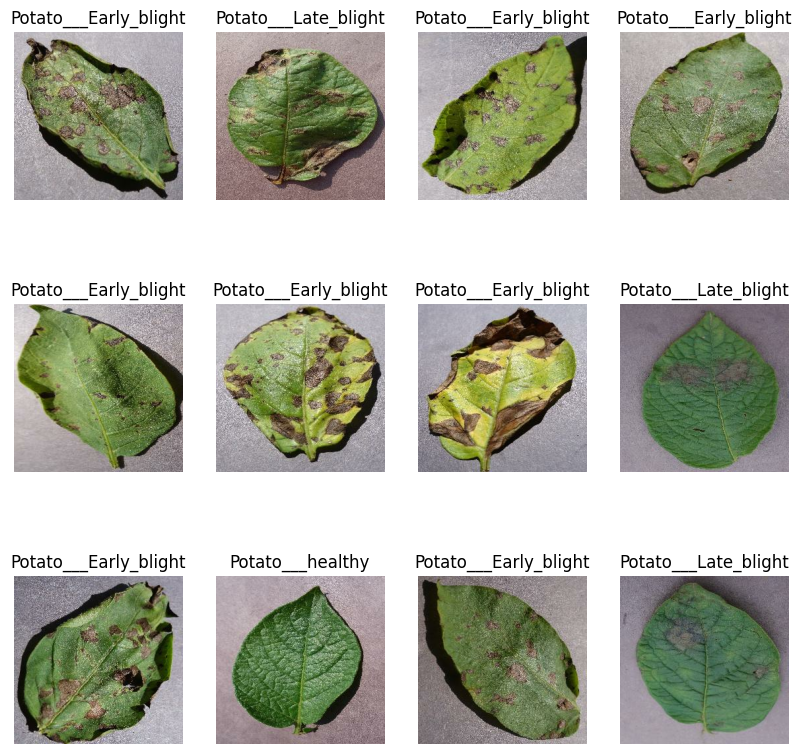

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow (image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis("off")

DATA SPLITTING

In [8]:
DATASET_SIZE = len(dataset)
TRAIN_RATIO, TEST_RATIO, VAL_RATIO = 0.8, 0.1, 0.1

TRAIN = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))
NOT_TRAIN = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO)) # NOW THIS DATASET WOULD BE DIVIDED INTO TEST AND VAL

VAL = NOT_TRAIN.take(int(TEST_RATIO*DATASET_SIZE))
TEST = NOT_TRAIN.skip(int(TEST_RATIO*DATASET_SIZE))

print (len(TRAIN),len(TEST), len(VAL))

54 8 6


DATA AUGMENTATION

In [9]:
TRAIN = TRAIN.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
VAL = VAL.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
TEST = TEST.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
Augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL BUILDING

In [11]:
model = models.Sequential([
    Augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(32,256, 256, 3)),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2,)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax"),
])

model.build(input_shape=(32, 256, 256, 3))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [13]:
model.compile (
    optimizer = 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

MODEL TRAINING

In [ ]:
history= model.fit (
    TRAIN,
    batch_size = 32,
    validation_data = VAL,
    epochs= 50, verbose= 1,
)

Epoch 1/50
54/54 [==============================] - 342s 607ms/step - loss: 0.9138 - accuracy: 0.4959 - val_loss: 0.8610 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.8045 - accuracy: 0.5966 - val_loss: 0.5492 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5746 - accuracy: 0.7836 - val_loss: 0.4732 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5141 - accuracy: 0.8044 - val_loss: 0.5767 - val_accuracy: 0.7500
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.4410 - accuracy: 0.8287 - val_loss: 0.5085 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3407 - accuracy: 0.8721 - val_loss: 0.3075 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3388 - accuracy: 0.8692 - val_loss: 0.4602 - val_accuracy: 0.8125
Epoch 8/50

In [26]:
scores = model.evaluate (TEST)

8/8 [==============================] - 0s 26ms/step - loss: 0.0745 - accuracy: 0.9784


MODEL ANALYSIS

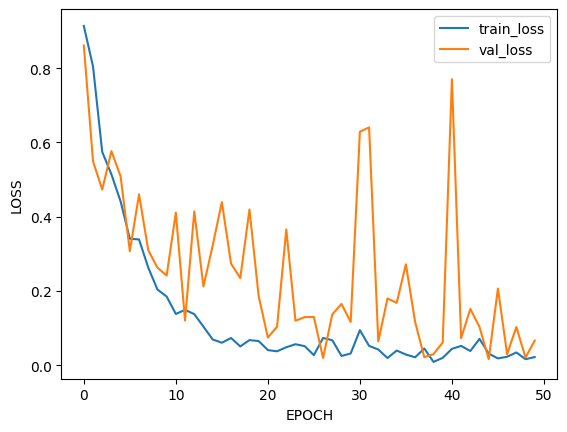

In [27]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss); plt.plot(val_loss)
plt.xlabel ('EPOCH'); plt.ylabel('LOSS')
plt.legend(['train_loss', 'val_loss'])
plt.show()

actual label:  Potato___Early_blight
1/1 [==============================] - 0s 40ms/step
printed label:  Potato___Early_blight


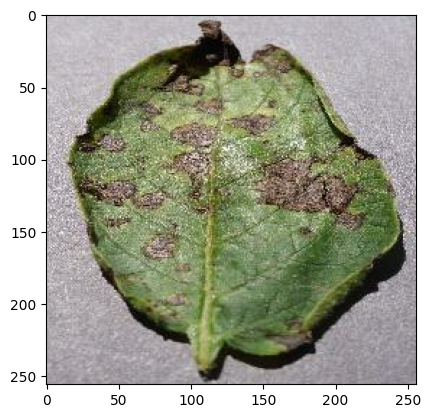

In [25]:
for images_batch, labels_batch in TEST.take(1):
    img= images_batch[0].numpy().astype("uint8")
    plt.imshow(img)

    print("actual label: ", class_names[labels_batch[0].numpy()])
    pred = model.predict(images_batch)
    print("printed label: ", class_names[np.argmax(pred[0])])

MODEL SAVE FOR DEPLOYMENT

In [24]:
model.save ("./models", save_format="tf")